# Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from glob import glob

In [2]:
from math import log10
def eng_str(x, u=0, n=1):
    """Print formatted value and its uncertainty in engineering format"""
    y = abs(x)
    exponent = int(log10(y))
    engr_exponent = exponent - exponent%3
    z = y/10**engr_exponent
    sign = '-' if x < 0 else ''
    fmt = "{z:.%df}" % (n)
    xStr = sign+fmt.format(z=z)
    
    # uncertainty
    yU = abs(u)
    zU = yU/10**engr_exponent
    fmtU = "{zU:.%df}" % (n)
    if engr_exponent != 0:
        uStr = " ± "+fmtU.format(zU=zU)+'e'+str(engr_exponent)
    else:
        uStr = " ± "+fmtU.format(zU=zU)
    return xStr + uStr

print(eng_str(123456, 3456, n=1))

123.5 ± 3.5e3


# Read in Your Data
The `glob` function allows you to find files whose names match a pattern. We are looking in the folder `Data` for files ending with `.csv`.

0: Data/20181112a.csv
1: Data/testData.csv
2: Data/testData1.csv
Enter file number: 0
Getting data from Data/20181112a.csv


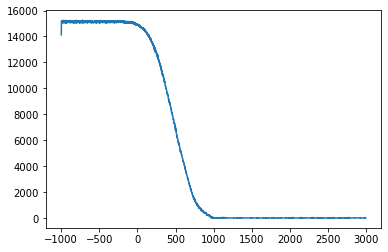

In [11]:
dataFolder = "Data"
globMatch = "*.csv"
files = glob("/".join([dataFolder,globMatch]))
for (i, f) in enumerate(files):
    print("{}: {}".format(i, f))
iFile = int(input("Enter file number: "))
dataFile = files[iFile]
figName = "Figures/" + dataFile[dataFile.find("/")+1:dataFile.rfind('.')] + r"_%.03d.png"

print("Getting data from {}".format(dataFile))
data = np.genfromtxt(dataFile, comments='#', delimiter=',')
pos = data[:,2]
I = data[:,3]
# Do a quick plot
plt.plot(pos, I)
pass

[False False False ... False False False]


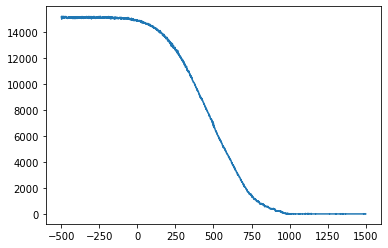

In [20]:
print((pos > 500) & (pos < 1500))
iGood = np.where((pos > -500) & (pos < 1500))
plt.plot(pos[iGood], I[iGood])

In [4]:
print(dataFile)
print(dataFile.find('/'))
figName = "Figures/" + dataFile[dataFile.find("/")+1:dataFile.rfind('.')] + r"_%.03d.png"
print(figName)
print(figName%12)

Data/20181112a.csv
4
Figures/20181112a_%.03d.png
Figures/20181112a_012.png


# Estimate Fit Parameters

In [5]:
IStart = np.median(I[:10])
IEnd = np.median(I[-10:])

def negErfc(x):
    return 2.0 - sp.special.erfc(x)

if IStart > IEnd:
    bErf = False
    fcn = sp.special.erfc
else:
    bErf = True
    fcn = negErfc
    
def beamProfile(pos, I0, pos0, width):
    return I0 * fcn((pos - pos0) / width)
    
I0Est = 0.5 * np.max([IStart, IEnd])
print(IStart, IEnd, I0Est)
halfIdx = (np.abs(I - I0Est)).argmin()
posEst = pos[halfIdx]
print(halfIdx, posEst)
eIdx = (np.abs(I - I0Est / np.sqrt(np.pi))).argmin()
widthEst = 2.0 * np.abs(pos[halfIdx] - pos[eIdx])
print(eIdx, pos[eIdx], I[eIdx], widthEst)

15121.95 0.0 7560.975
1511 473.68
1648 607.21 4240.15 267.06000000000006


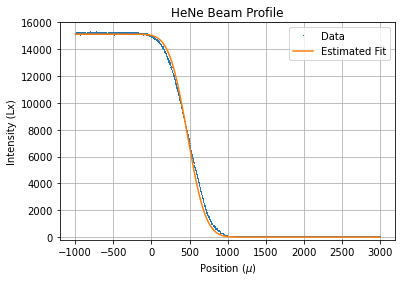

In [6]:
pos0 = posEst
width = widthEst
I0 = I0Est
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pos, I, ',', label='Data')
#ax.set_xlim(-200,1200)
ax.set_ylim(-200,16000)
ax.grid()
ax.plot(pos, beamProfile(pos, I0, pos0, width), label='Estimated Fit')
ax.legend()
ax.set_xlabel('Position ($\mu$)')
ax.set_ylabel('Intensity (Lx)')
ax.set_title('HeNe Beam Profile')
pass

# Do a Least-Squares Fit

In [7]:
initParams = np.array((I0Est, posEst, widthEst))
popt, pcov = curve_fit(beamProfile, pos, I, p0=initParams)
# print results
print("Initial Parameters = ", initParams)
print("Best Parameters = ", popt)
perr = np.sqrt(np.diag(pcov))
print("Uncertainty in parameters = ", perr)

(I0Fit, posFit, widthFit) = popt
(I0Unc, posUnc, widthUnc) = perr
IFit = beamProfile(pos, I0Fit, posFit, widthFit)
print(eng_str(I0Fit, I0Unc, n=3))
print(eng_str(posFit, posUnc, n=1))
print(eng_str(widthFit, widthUnc, n=1))


Initial Parameters =  [7560.975  473.68   267.06 ]
Best Parameters =  [7569.63224577  470.55389071  312.82945839]
Uncertainty in parameters =  [0.86113275 0.11129007 0.21598674]
7.570 ± 0.001e3
470.6 ± 0.1
312.8 ± 0.2


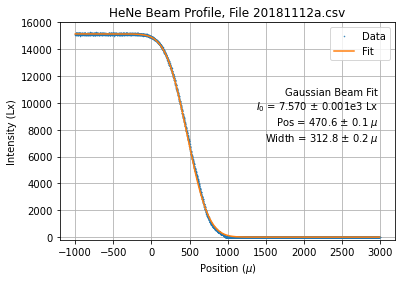

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pos, I, '.', label='Data', ms=1)
#ax.set_xlim(-200,1200)
ax.set_ylim(-200,16000)
ax.grid()
ax.plot(pos, IFit, label='Fit')
text = f"""Gaussian Beam Fit
$I_0$ = {eng_str(I0Fit, I0Unc, n=3)} Lx
Pos = {eng_str(posFit, posUnc, n=1)} $\mu$
Width = {eng_str(widthFit, widthUnc, n=1)} $\mu$"""
ax.legend()
ax.text(0.95, 0.7, text, horizontalalignment='right', verticalalignment='top', \
        transform=ax.transAxes)
ax.set_xlabel('Position ($\mu$)')
ax.set_ylabel('Intensity (Lx)')
ax.set_title(f'HeNe Beam Profile, File {dataFile[dataFile.find("20"):]}')
fig.savefig(figName%0, dpi=300)
pass

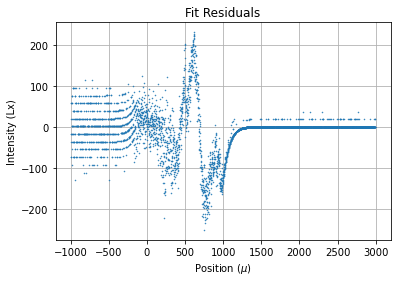

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(pos[1:], (I - IFit)[1:], '.', ms=1)
ax.grid()
ax.set_xlabel('Position ($\mu$)')
ax.set_ylabel('Intensity (Lx)')
ax.set_title('Fit Residuals')
fig.savefig(figName%1, dpi=300)
pass